In [24]:
import xgboost as xgb
from data_utils import load_features, preds_to_df
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
patient = 1

%time X_corr, y, files_1 = load_features('train_{}'.format(patient), [CorrelationMatrix()])
%time X_abs_mean, y, files_2 = load_features('train_{}'.format(patient), [Abs(), Mean()])
%time X_stats, y, files_3 = load_features('train_{}'.format(patient), [Stats()])
%time X_fft, y, files_3 = load_features('train_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])

Wall time: 159 ms
Wall time: 7 ms
Wall time: 47 ms
Wall time: 2.44 s


In [204]:
X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
X = np.hstack([X_fft, X_abs_mean, X_corr, X_stats])
sm = SMOTE(kind='regular')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)
# X_train, y_train = sm.fit_sample(X_train, y_train)

In [205]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [226]:
param = {'bst:max_depth':1, 'bst:eta':.2, 'silent':0, 'objective':'binary:logistic', 'subsample':0.9,'colsample_bytree':0.9 }
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist  = [(dtrain,'train'), (dtest,'eval')]
num_round = 1000
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=50 )
roc_auc_score(np.round(bst.predict(dtrain)), y_train), roc_auc_score(np.round(bst.predict(dtest)), y_test)

Will train until eval error hasn't decreased in 50 rounds.
[0]	train-auc:0.553317	eval-auc:0.490991
[1]	train-auc:0.653439	eval-auc:0.538342
[2]	train-auc:0.687485	eval-auc:0.545635
[3]	train-auc:0.752610	eval-auc:0.663932
[4]	train-auc:0.770151	eval-auc:0.655280
[5]	train-auc:0.771919	eval-auc:0.659749
[6]	train-auc:0.789213	eval-auc:0.656138
[7]	train-auc:0.798882	eval-auc:0.709120
[8]	train-auc:0.807277	eval-auc:0.723545
[9]	train-auc:0.810224	eval-auc:0.739704
[10]	train-auc:0.828811	eval-auc:0.746782
[11]	train-auc:0.841950	eval-auc:0.737702
[12]	train-auc:0.839592	eval-auc:0.743065
[13]	train-auc:0.847702	eval-auc:0.736379
[14]	train-auc:0.861992	eval-auc:0.751055
[15]	train-auc:0.864796	eval-auc:0.754683
[16]	train-auc:0.870291	eval-auc:0.757508
[17]	train-auc:0.877688	eval-auc:0.746908
[18]	train-auc:0.879304	eval-auc:0.744780
[19]	train-auc:0.890381	eval-auc:0.735521
[20]	train-auc:0.891968	eval-auc:0.735736
[21]	train-auc:0.903406	eval-auc:0.728353
[22]	train-auc:0.910641	eva

(0.95594125500667559, 0.43774703557312256)

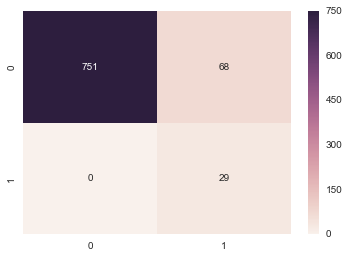

In [184]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtrain)), y_train), annot=True, fmt='d')
plt.show()

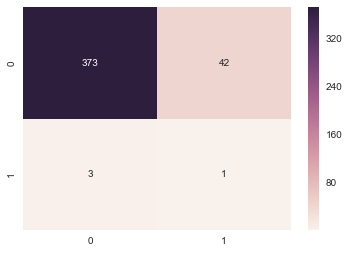

In [185]:
sns.heatmap(confusion_matrix(np.round(bst.predict(dtest)), y_test), annot=True, fmt='d')
plt.show()

In [118]:
%time X_corr, files = load_features('test_{}'.format(patient), [CorrelationMatrix()])
%time X_mean_abs, files_2 = load_features('test_{}'.format(patient), [Mean(), Abs()])
%time X_stats, files_3 = load_features('test_{}'.format(patient), [Stats()])
%time X_fft, files_3 = load_features('test_{}'.format(patient), [FFT(), Slice(1, 160), Magnitude(), Log10()])
X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
X_stats = X_stats.reshape(X_stats.shape[0], X_stats.shape[1]*X_stats.shape[2])
X = np.hstack([X_fft, X_mean_abs, X_corr, X_stats])


Wall time: 134 ms


In [119]:
dfinal = xgb.DMatrix(X)

In [105]:
# bst.save_model('corr_meanabs_stats_fft160_depth4_etahalf_{}.model'.format(patient))

In [106]:
from data_utils import preds_to_df

In [120]:
# preds_to_df(bst.predict(dfinal), files).to_csv(os.path.join('predictions', 'corr_xgboost_{}.csv'.format(patient)), index=False)

In [121]:
bst.predict(dfinal).astype(int).sum()

0